<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/Python_ARIMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


目的：日本の将来人口を、Ｐｙｔｈｏｎを使って推計してみます。  
　　　今回は場合分けをせず、時系列分析します。

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データ解析を支援する機能を提供する[pandas](https://pandas.pydata.org/)や、数値計算用の[numpy](https://numpy.org/)、統計モデル作成に便利な[statsmodels](https://www.statsmodels.org/stable/index.html)や[pmdarima](https://pypi.org/project/pmdarima/)、データプロット用の[matplotlib](https://matplotlib.org/)といったライブラリを使います。

In [13]:
# 該当ＵＲＬを変数に格納
repo = "https://raw.githubusercontent.com/u-10bei/Population_Projections/"
popURL = repo + "main/data/population_jp_year.csv"

# ライブラリの読み込み
import pandas as pd
from dateutil.relativedelta import relativedelta

# ネット上のファイル読み込み
pop_csv = pd.read_csv( popURL,
                      parse_dates = [ 'Year' ])
pop_csv.Year = pop_csv.Year.apply( lambda x: x + relativedelta( months = 9 ))
pop_df = pop_csv[[ 'Year', 'Total' ]]\
          .astype({'Total': float }).set_index( 'Year' )

# 手順２　データの可視化

まず、データをプロットしてみます。  

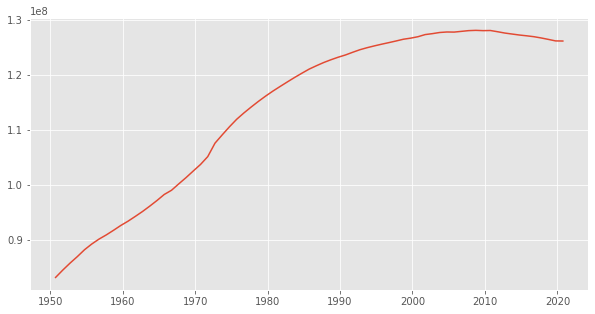

In [14]:
# ライブラリの読み込み
import matplotlib.pyplot as plt
plt.style.use( 'ggplot' )

# グラフのサイズ変更
plt.rcParams['figure.figsize'] = [10, 5]

# 総人口のグラフ
plt.plot( pop_df )

次に、自己相関を確認してみます。

/usr/local/lib/python3.7/dist-packages/pmdarima/utils/visualization.py:223: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


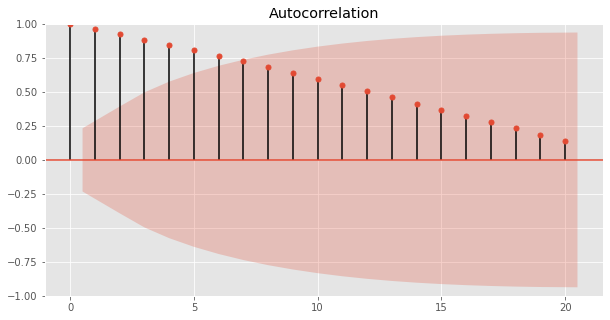

In [15]:
# ライブラリの読み込み
import pmdarima as pm

# 自己相関のグラフ
pm.utils.plot_acf( pop_df,
                   lags = 20,
                   alpha = .05 )

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

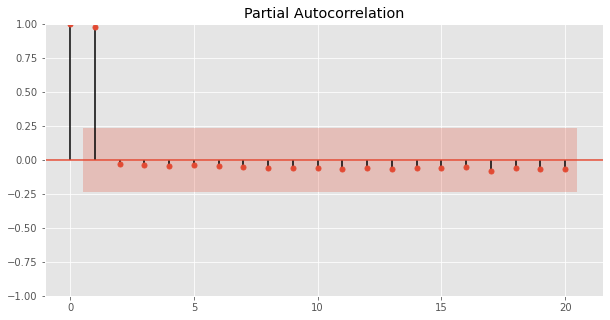

In [16]:
# 偏自己相関のグラフ
pm.utils.plot_pacf( pop_df,
                    lags = 20,
                    alpha = .05 )

# 手順３　学習データと予測データの分類

２０１５年までのデータを学習データとし、その後５年間のデータを予測データとします。

In [17]:
# 学習データと予測データ
prow_test = 5
pop_test = pop_df.tail()
pop_train = pop_df.head( prow_test * -1 )

# 手順４　ＡＲＩＭＡモデルによる予測

まず、学習データを使ってＡＲＩＭＡモデルを推定します。

In [18]:
# ＡＲＩＭＡモデルの推定
pop_arima = pm.auto_arima( pop_train,
                           information_criterion = 'aic' )
pop_arima

ARIMA(order=(0, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

では、ＡＲＩＭＡ（０，２，０）が推定されたので、モデリングと予測をしてみます。

In [19]:
# モデリング
from statsmodels.tsa.arima.model import ARIMA
pop_arima = ARIMA( pop_train, order = (0, 2, 0)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-OCT will be used.
  self._init_dates(dates, freq)


In [20]:
# ＡＲＩＭＡによる予測
pop_arima_f = pop_arima.predict('2016', '2020')
pop_arima_f

2016-10-01    126953000.0
2017-10-01    126811000.0
2018-10-01    126669000.0
2019-10-01    126527000.0
2020-10-01    126385000.0
Freq: AS-OCT, Name: predicted_mean, dtype: float64

# 手順５　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

In [21]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = repo + "main/data/forecast_ipss.csv"

# ネット上のファイル読み込み
ipss_csv = pd.read_csv( ipssURL,
                        parse_dates = [ 'Year' ])
ipss_csv.Year = ipss_csv.Year.apply( lambda x: x + relativedelta( months = 9 ))
ipss_test = ipss_csv.set_index( 'Year' )

# ライブラリの読み込み
import numpy as np

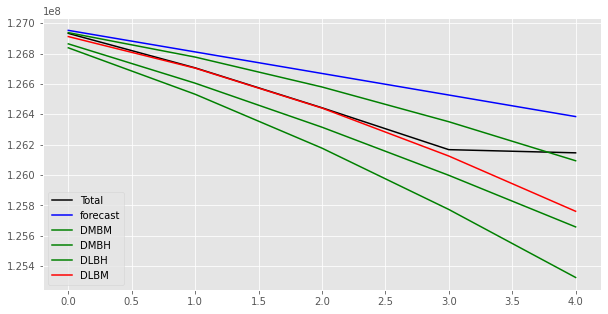

In [22]:
# 予測と実測の比較（グラフ）
x_axis = np.arange(pop_arima_f.shape[0])
plt.plot( x_axis,
          pop_test,
          label = "Total",
          color = 'black' )
plt.plot( x_axis,
          pop_arima_f,
          label="forecast",
          color='blue')
plt.plot( x_axis,
          ipss_test.DMBM,
          label="DMBM",
          color='green')
plt.plot( x_axis,
          ipss_test.DMBH,
          label="DMBH",
          color='green')
plt.plot( x_axis,
          ipss_test.DLBH,
          label="DLBH",
          color='green')
plt.plot( x_axis,
          ipss_test.DLBM,
          label="DLBM",
          color='red')
plt.legend()
plt.show()

どうやら、実データより２０万人弱、高く予測してしまったようです。  
人口変動の要因は一つではないので、もう少し細かいモデルが必要のようです。

# 次のステップ



*   同じ事をRでやってみる。　->　[Ｒ_人口推計_その１](https://colab.research.google.com/drive/11iBGtzEXfOynuyhiYJIXVgo-OojV0B0G?usp=sharing)

*   色んなモデルを当てはめてみる　->　こちら
*   人口方程式の考え方に沿ってみる　->　こちら
